In [1]:
import gc

import numpy as np
import pandas as pd

import back_testing as bt

gc.collect()

0

In [2]:
price_df = pd.read_csv('./data/sp500.csv')
price_df.set_index('datadate', inplace=True)
df_ = price_df[['AAPL', 'DIS', 'XOM', 'INTC', 'MSFT', 'AMZN', 'NVDA', 'CRM', 'GOOG', 'TSLA']].dropna(axis=0)
df_.index = pd.to_datetime(df_.index, format='%Y-%m-%d')

idx_df = pd.read_csv('./data/GSPC.csv', index_col='Date')
idx_df = idx_df.pct_change().apply(lambda x: np.log1p(x)).dropna()
idx_df.index = pd.to_datetime(idx_df.index, format='%Y-%m-%d')

weight_GAT_TCN = pd.read_csv('data/GAT_TCN_weight.csv', index_col=0)
weight_GAT_TCN.index = pd.to_datetime(weight_GAT_TCN.index, format='%Y-%m-%d')

weight_LGBM = pd.read_csv('data/LGBM_weight.csv', index_col=0)
weight_LGBM.index = pd.to_datetime(weight_LGBM.index, format='%Y-%m-%d')

returns = bt.get_momentum(df_, 1)
momentum_12m = bt.get_momentum(df_, 12)

weight_dict = {}
str_name_lst = ['static', 'MR', 'TF', 'DM', 'GTAA', 'GTAA5', 'LGBM', 'GAT_TCN', 'S&P 500']

weight_dict[str_name_lst[0]] = bt.buy_and_hold_strategy(df_)
weight_dict[str_name_lst[1]] = bt.mean_reversion_zscore_strategy(df_)
weight_dict[str_name_lst[2]] = bt.trend_following_zscore_strategy(df_)
weight_dict[str_name_lst[3]] = bt.dual_momentum_strategy(momentum_12m)
weight_dict[str_name_lst[4]] = bt.gtaa_aggressive3_strategy(momentum_12m, df_)
weight_dict[str_name_lst[5]] = bt.gtaa5_momentum_strategy(momentum_12m, df_)
weight_dict[str_name_lst[6]] = weight_LGBM[weight_dict[str_name_lst[3]].columns]
weight_dict[str_name_lst[7]] = weight_GAT_TCN[weight_dict[str_name_lst[3]].columns]

In [3]:
for i in range(7):
    weight_dict[str_name_lst[i]] = weight_dict[str_name_lst[i]].loc['2023-01-05':, :]

In [4]:
# for model in ['GAT_TCN']:
#     previous_index = weight_dict[model].index[1:]
#     weight_dict[model]=weight_dict[model].iloc[:-1]
#     weight_dict[model].index=previous_index

In [5]:
result_df = pd.DataFrame()
for str_name in str_name_lst[:-1]:
    print(str_name)
    result_df = bt.return_Table(weight_dict[str_name], returns, result_df, True, 'Neutral', True, 0.0002)

result_df = pd.concat([result_df, idx_df], axis=1)
result_df.columns = str_name_lst
# result_df.to_csv('./general_results/result.csv')

static
MR
TF
DM
GTAA
GTAA5
LGBM
GAT_TCN


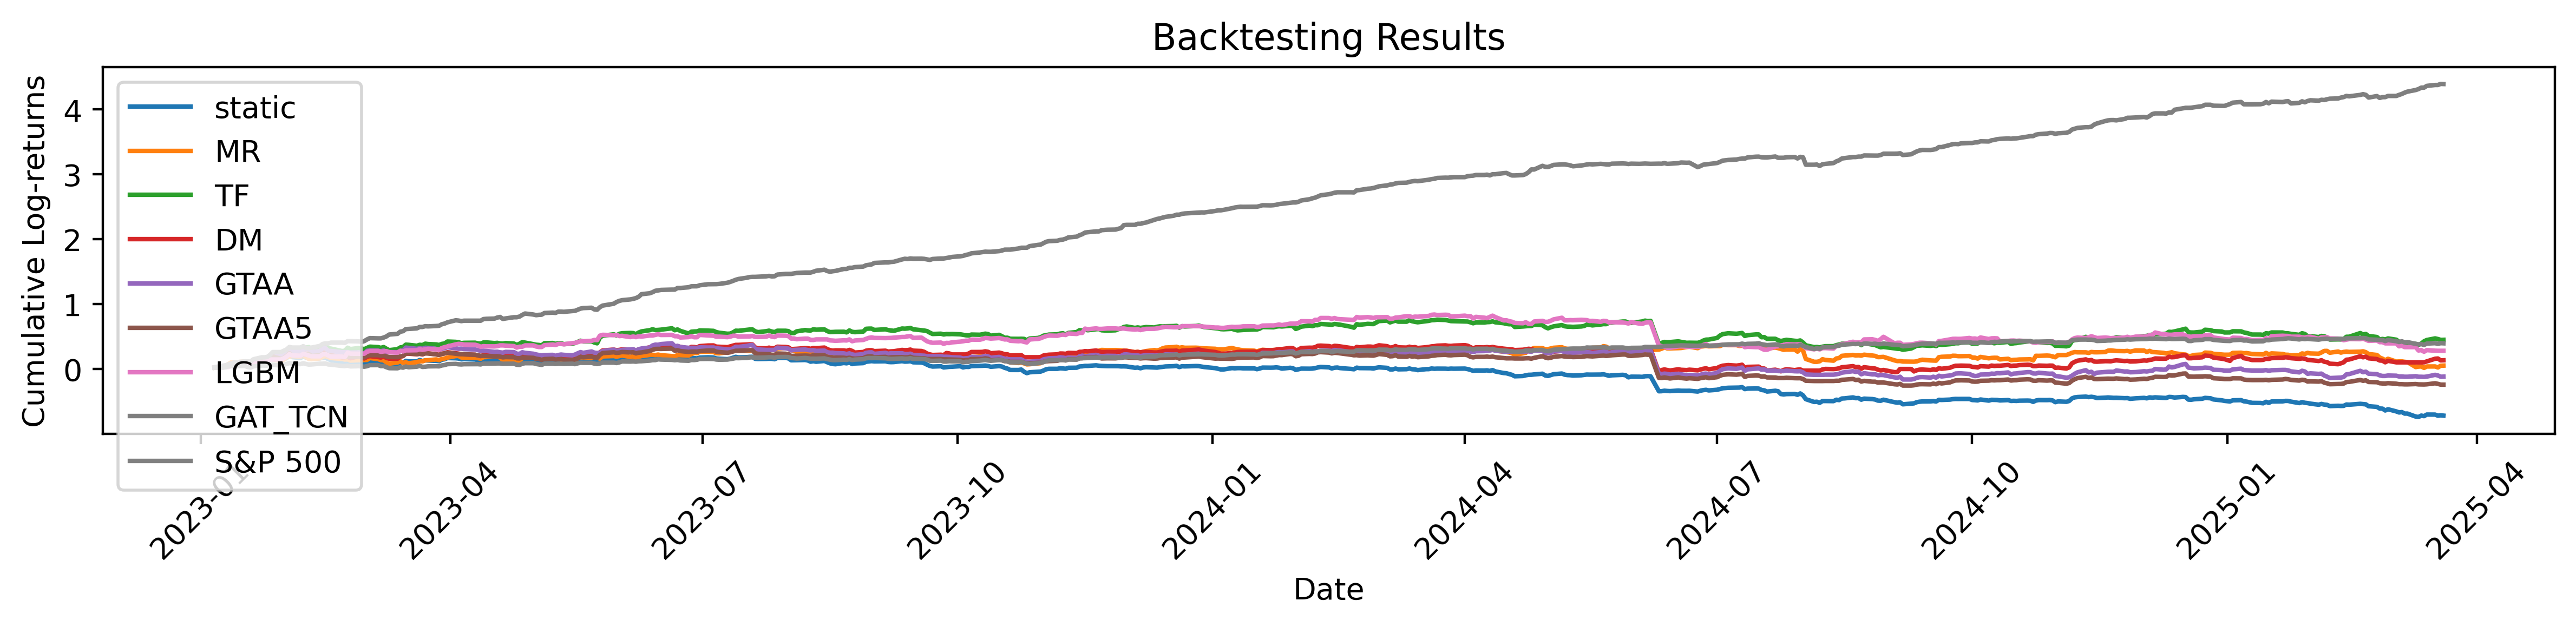

In [6]:
bt.plot_result(result_df.loc[pd.to_datetime('2023-01-06'):], True)

In [7]:
for str_name in str_name_lst[:-1]:
    print(f"{str_name} : {bt.cal_turnover(weight_dict[str_name])}")

static : 0.00
MR : 230.67
TF : 92.00
DM : 110.82
GTAA : 155.33
GTAA5 : 125.20
LGBM : 369.66
GAT_TCN : 319.33


In [8]:
metric = bt.METRICS(result_df, result_df.index)
metric.cal_describe()
metric.cal_monthly_statistics()

In [9]:
metric.annual_statistics

,static,MR,TF,DM,GTAA,GTAA5,LGBM,GAT_TCN,S&P 500
count,2761.0,2761.0,2761.0,2761.0,2761.0,2761.0,2761.0,2761.0,2761.0
cumulative return,-0.00319,0.0002,0.00196,0.00058,-0.00055,-0.00107,0.00122,0.01926,0.00486
annualized return mean,-0.00319,0.0002,0.00196,0.00058,-0.00055,-0.00107,0.00122,0.01926,0.00486
annualized return std,0.02573,0.02684,0.03682,0.034,0.03417,0.03058,0.03497,0.0241,0.03886
annualized return downside std,0.05734,0.04639,0.08734,0.087,0.08424,0.08094,0.09155,0.055,0.03259
sharpe ratio,-0.12388,0.0075,0.05309,0.01699,-0.0161,-0.03501,0.035,0.79931,0.12498
sortino ratio,-0.05559,0.00434,0.02239,0.00664,-0.00653,-0.01323,0.01337,0.35026,0.14901
gross profit,2.50392,3.41561,4.06259,3.39502,3.19874,2.46158,3.40478,5.35038,10.49301
gross loss,-3.23845,-3.36928,-3.61317,-3.26216,-3.32534,-2.70804,-3.12334,-0.96,-9.37837
profit factor,0.77318,1.01375,1.12438,1.04073,0.96193,0.90899,1.09011,5.57329,1.11885


In [10]:
metric.monthly_statistics

,static,MR,TF,DM,GTAA,GTAA5,LGBM,GAT_TCN,S&P 500
Mean,-0.00027,0.00002,0.00016,0.00005,-0.00005,-0.00009,0.0001,0.00159,0.0004
Standard deviation,0.00733,0.00765,0.01044,0.00965,0.0097,0.00869,0.00992,0.00688,0.011
Standard error,0.00014,0.00015,0.0002,0.00018,0.00018,0.00017,0.00019,0.00013,0.00021
t-statistic,[-1.8809],[0.1104],[0.8375],[0.2846],[-0.2523],[-0.5402],[0.5294],[8.1219],[2.0924]
Min,-0.23072,-0.12786,-0.3598,-0.35876,-0.35876,-0.35666,-0.3571,-0.11414,-0.12765
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.00377
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00068
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00565
Max,0.0395,0.07118,0.08752,0.06244,0.05569,0.04652,0.06829,0.0568,0.08968
Skew,-11.86724,-1.87828,-14.37278,-18.41099,-18.30286,-25.01218,-16.77658,-0.15454,-0.80372
